In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

In [3]:
phantom_data=scipy.io.loadmat('Bay5.mat')

In [4]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]
cleaned = phantom_data["NoiseNet_Cleaned"]

In [5]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)
gt_skew = sp.stats.skew(gt,axis=1)
fmri_skew = sp.stats.skew(fmri,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

75 201


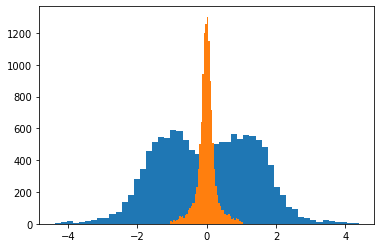

In [6]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

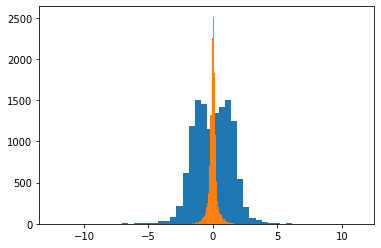

In [7]:
skew_idx = np.argsort(gt_nooutliers)
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

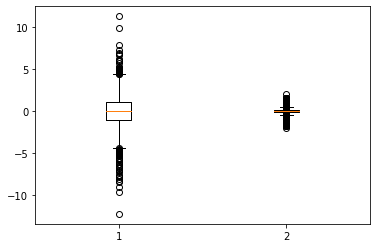

In [8]:
_ = plt.boxplot([gt_skew,fmri_skew])

In [9]:
gt_norm = (gt - gt_mean[:,np.newaxis])/gt_std[:,np.newaxis]
fmri_norm = (fmri - fmri_mean[:,np.newaxis])/fmri_std[:,np.newaxis]

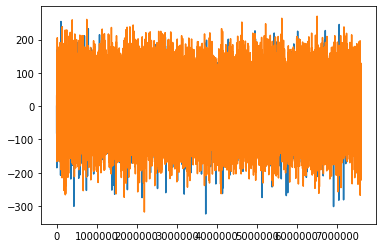

In [10]:
idx = 800
gt_data = gt[skew_idx].flatten()
fmri_data = fmri[skew_idx].flatten()
plt.plot(gt_data)
plt.plot(fmri_data)

In [11]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,50)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [49:11<00:00,  1.36draws/s]  
The acceptance probability does not match the target. It is 0.8977232071471085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924882433645619, but should be close to 0.8. Try to increase the number of tuning steps.


In [29]:
#pm.traceplot(posterior_2)

In [12]:
pm.summary(posterior_2)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,26.945890,0.008499,0.000219,26.930509,26.963801,1282.703219,0.999098
ampl_noise,0.742165,0.001037,0.000031,0.740078,0.744047,1165.931344,1.000457


In [13]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/thermal:",sigma_mult**2/sig_total**2)

sigma mult: 13.662790746658292
sigma thermal: 26.945890169469262
sigma thermal normalized 1.4637044558255126
sigma thermal normalized error 0.00046164955502970493
sigma total noise fitted: 30.211799814179752
sigma total (fmri-gt): 29.919496252624217
sigma GT: 18.409379067082288
signal to noise ratio: 0.3713001152213828
sigma multi/thermal: 0.20451522161068358


In [32]:
# here is a more realistic model
#with pm.Model() as multi_noise2:
#    sigma1 = pm.Uniform('sigma1',0,5)
#    ampl1 = pm.Uniform('ampl1',0,5)
#    noise_thermal = pm.Normal('noise_thermal',mu=gt_data, sigma=sigma1,shape=len(gt_data))
#    noise_multi = pm.Normal('noise_multi',mu=0, sigma=ampl1*np.abs(gt_data),shape=len(gt_data))
    
#    fmri = pm.Deterministic('fmri', noise_thermal + noise_multi)
#    fmri_observed = pm.Normal('fmri_observed', mu=fmri, tau=10000,observed=fmri_data)

#    posterior = pm.sample(2000, tune=1000)

In [33]:
#pm.traceplot(posterior['sigma1'])

In [34]:
#pm.traceplot(posterior['ampl1'])